In [35]:
import re
import json

import httpx
import trio
import bs4
import pandas as pd

%autoawait trio

In [4]:
productiontypes = [
    ("productionType.values", f"B{k:02}")
    for k in range(1,20)
]
productiontypes

[('productionType.values', 'B01'),
 ('productionType.values', 'B02'),
 ('productionType.values', 'B03'),
 ('productionType.values', 'B04'),
 ('productionType.values', 'B05'),
 ('productionType.values', 'B06'),
 ('productionType.values', 'B07'),
 ('productionType.values', 'B08'),
 ('productionType.values', 'B09'),
 ('productionType.values', 'B10'),
 ('productionType.values', 'B11'),
 ('productionType.values', 'B12'),
 ('productionType.values', 'B13'),
 ('productionType.values', 'B14'),
 ('productionType.values', 'B15'),
 ('productionType.values', 'B16'),
 ('productionType.values', 'B17'),
 ('productionType.values', 'B18'),
 ('productionType.values', 'B19')]

In [5]:
async with httpx.AsyncClient(
    base_url="https://transparency.entsoe.eu",
) as client:
    res = await client.get(
        url="/generation/r2/actualGenerationPerProductionType/show",
        params=list({
            "areaType": "BZN",
            "viewType": "GRAPH",
            "dateTime.dateTime": "23.03.2023 00:00|CET|DAYTIMERANGE",
            "dateTime.endDateTime": "23.03.2023 00:00|CET|DAYTIMERANGE",
            "dateTime.timezone": "CET_CEST",
            "area.values": "CTY|10YCH-SWISSGRIDZ!BZN|10YCH-SWISSGRIDZ",
        }.items()) + productiontypes,
        headers={"X-Requested-With": "XMLHttpRequest"},
    )

In [6]:
!pip install beautifulsoup4

In [10]:
assert res.headers["content-type"] == "text/html;charset=UTF-8"
soup = bs4.BeautifulSoup(res.content.decode("utf-8"))

In [19]:
javascript_str = soup.find("script").text
match = re.search(r"var\s+chart\s*=\s*(\{.*\})\s*;", javascript_str, re.S)
assert match is not None

In [24]:
data = json.loads(match.group(1))

In [46]:
columns = {
    k:" ".join(v["title"].split())
    for k,v in
    data["graphDesign"].items()
}
columns

{'val6': 'Wind Onshore Generation',
 'val5': 'Solar Generation',
 'val4': 'Nuclear Generation',
 'val3': 'Hydro Water Reservoir Generation',
 'val2': 'Hydro Run-of-river and poundage Generation',
 'val1': 'Hydro Pumped Storage Generation'}

In [47]:
df = pd.DataFrame(
    data["chartData"]
).set_index(data["categoryName"]).astype(float).rename(columns=columns)
df.head()

,Wind Onshore Generation,Solar Generation,Nuclear Generation,Hydro Water Reservoir Generation,Hydro Run-of-river and poundage Generation,Hydro Pumped Storage Generation
cat,,,,,,
00:00,0.0,0.0,3002.0,237.0,164.0,172.0
01:00,0.0,0.0,3003.0,209.0,149.0,99.0
02:00,0.0,0.0,3003.0,249.0,148.0,83.0
03:00,0.0,0.0,3003.0,238.0,149.0,86.0
04:00,0.0,0.0,3003.0,240.0,161.0,97.0


<AxesSubplot:xlabel='cat'>

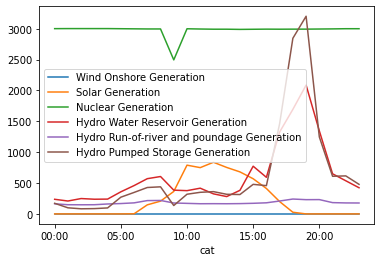

In [48]:
df.plot()

In [49]:
df.index

Index(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00',
       '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00',
       '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'],
      dtype='object', name='cat')